In [1]:
%pylab inline
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from scipy.stats import ttest_rel
import copy
import pickle
import pandas as pd
import copy

from sklearn.preprocessing import MinMaxScaler


import numpy as np
from numpy import linalg as LA
import scipy
from scipy.sparse import csr_matrix
from sklearn import preprocessing

from gensim.models import Word2Vec
from gensim import utils
from gensim.corpora import Dictionary
from gensim.models.lsimodel import LsiModel

from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr


from sklearn.decomposition import PCA

In [341]:
we_model_name = "sg_dim300_min200_win5"
we_vector_size = 300

we_model_dir = "/share/home/navid/wordembeddings/word2vecgensim/wikipedia/wiki-english-20171001/%s" % we_model_name
print (we_model_dir)

/share/home/navid/wordembeddings/word2vecgensim/wikipedia/wiki-english-20171001/sg_dim300_min200_win5


In [4]:
we_model = Word2Vec.load(we_model_dir+'/model.gensim')

print ('loading done!')

loading done!


In [510]:
def get_recSG_vecs(words):
    
    recSG_vecs = {}
    for word in words:
        _idx = we_model.wv.vocab[word].index
        _vec = we_model.wv.vectors[_idx]
        
        recSG_vecs[word] = scipy.special.expit(np.dot(we_model.trainables.syn1neg, _vec))
    
    return recSG_vecs

get_recSG_vecs(['book'])

{'book': array([0.00565136, 0.02252608, 0.02769055, ..., 0.00346204, 0.00264165,
        0.00321505], dtype=float32)}

In [511]:
def Cosine(vec1, vec2):
    return 1 - scipy.spatial.distance.cosine(vec1, vec2)

def meanCosine(vec, set_vecs):
    return np.mean([Cosine(vec, _set_vec) for _set_vec in set_vecs])

def NegDifNorm(vec1, vec2):
    return -np.linalg.norm((vec1/np.linalg.norm(vec1)) - (vec2/np.linalg.norm(vec2)))

def get_recSG_vecs_similarity(word_from, words_to):
    recSG_vecs_from = get_recSG_vecs([word_from])
    recSG_vecs_to = get_recSG_vecs(words_to)
    
    sims_recSG={}
    for word_to in words_to:
        if word_to in we_model.wv.vocab:
            sims_recSG[word_to] = Cosine(recSG_vecs_from[word_from], recSG_vecs_to[word_to])
    
    return sims_recSG

get_recSG_vecs_similarity('book', ['book', 'library'])

{'book': 1.0, 'library': 0.5894790887832642}

In [512]:
len(we_model.wv.vocab)

197549

## Gender Biasing Quantification

In [513]:
job_tuples=[]
with open('resources/wordlist_occupations.txt') as fr:
    for l in fr:
        _tuple=l.strip('\n').split(',')
        if _tuple[0] in we_model.wv.vocab:
            job_tuples.append(_tuple)
print (len(job_tuples))



497


In [514]:
wordpairs_debiasing_direction = []
with open('resources/wordpairs_direction.txt') as fr:
    for l in fr:
        wordpairs_debiasing_direction.append(l.strip().split(','))
print (len(wordpairs_debiasing_direction))



28


In [515]:
job_recSG_vecs = get_recSG_vecs([x[0] for x in job_tuples])


In [516]:
genderword_tuples = []

with open('resources/wordlist_genderspecific.txt') as fr:
    for l in fr:
        _tuple=l.strip('\n').split(',')
        if _tuple[0] in we_model.wv.vocab:
            _idx = we_model.wv.vocab[_tuple[0]].index
            genderword_tuples.append((_tuple[0], _tuple[1], _idx))
        else:
            print (_tuple[0])
print (len([x for x in genderword_tuples if x[1]=='f']))
print (len([x for x in genderword_tuples if x[1]=='m']))



28
28


In [517]:
fem_SG_vecs = []
masc_SG_vecs = []
fem_recSG_vecs = []
masc_recSG_vecs = []
for _tuple in genderword_tuples:
    if _tuple[1] == 'f':
        fem_SG_vecs.append(we_model.wv.vectors[we_model.wv.vocab[_tuple[0]].index])
        fem_recSG_vecs.append(get_recSG_vecs([_tuple[0]])[_tuple[0]])
    elif _tuple[1] == 'm':
        masc_SG_vecs.append(we_model.wv.vectors[we_model.wv.vocab[_tuple[0]].index])
        masc_recSG_vecs.append(get_recSG_vecs([_tuple[0]])[_tuple[0]])
    
fem_SG_centroid_vec = np.mean(np.array(fem_SG_vecs), axis=0)
masc_SG_centroid_vec = np.mean(np.array(masc_SG_vecs), axis=0)
fem_recSG_centroid_vec = np.mean(np.array(fem_recSG_vecs), axis=0)
masc_recSG_centroid_vec = np.mean(np.array(masc_recSG_vecs), axis=0)



In [518]:
#Gender dirction dense

_matrix_SG = []
_matrix_recSG = []
for a, b in wordpairs_debiasing_direction:
    _a_SG_vec = we_model.wv[a]
    _b_SG_vec = we_model.wv[b]
    #_matrix_SG.append((_a_SG_vec/np.linalg.norm(_a_SG_vec)) - (_b_SG_vec/np.linalg.norm(_b_SG_vec)))
    _matrix_SG.append((_a_SG_vec - _b_SG_vec)/2.0)
    _matrix_SG.append((_b_SG_vec - _a_SG_vec)/2.0)
    
    _a_recSG_vec = get_recSG_vecs([a])[a]
    _b_recSG_vec = get_recSG_vecs([b])[b]
    _matrix_recSG.append((_a_recSG_vec - _b_recSG_vec)/2.0)
    _matrix_recSG.append((_a_recSG_vec - _b_recSG_vec)/2.0)
    

_matrix_SG = np.array(_matrix_SG)
_matrix_recSG = np.array(_matrix_recSG)

pca = PCA(n_components = 10)
gendir_SG_vec = pca.fit(_matrix_SG).components_[0]
gendir_recSG_vec = pca.fit(_matrix_recSG).components_[0]




In [519]:
fem_exp_feature_vec = np.zeros(len(we_model.wv.vocab))
masc_exp_feature_vec = np.zeros(len(we_model.wv.vocab))
for _tuple in genderword_tuples:
    if _tuple[1] == 'f':
        fem_exp_feature_vec[_tuple[2]] = 1
    elif _tuple[1] == 'm':
        masc_exp_feature_vec[_tuple[2]] = 1


In [520]:
print (len([x for x in genderword_tuples if x[1]=='f']), len([x for x in genderword_tuples if x[1]=='m']))

28 28


## Calculating bias

In [521]:
job_recSG_1st_mean_bias = []
for job_tuple in job_tuples:
    _vec = job_recSG_vecs[job_tuple[0]]
    job_recSG_1st_mean_bias.append((job_tuple[0], np.dot(_vec, fem_exp_feature_vec)/np.sum(fem_exp_feature_vec) - np.dot(_vec, masc_exp_feature_vec)/np.sum(masc_exp_feature_vec),
                              np.dot(_vec, fem_exp_feature_vec)/np.sum(fem_exp_feature_vec), np.dot(_vec, masc_exp_feature_vec)/np.sum(masc_exp_feature_vec), job_tuple[1]))
    
job_recSG_1st_mean_bias.sort(key=lambda x: x[1])


In [522]:
job_SG_2nd_gendir_bias = []
for job_tuple in job_tuples:
    _vec = we_model.wv[job_tuple[0]]
    job_SG_2nd_gendir_bias.append((job_tuple[0], np.dot(_vec, gendir_SG_vec), 0.0, 0.0, job_tuple[1]))
    
job_SG_2nd_gendir_bias.sort(key=lambda x: x[1])


In [523]:
job_SG_2nd_mean_bias = []
for job_tuple in job_tuples:
    _vec = we_model.wv.vectors[we_model.wv.vocab[job_tuple[0]].index]
    job_SG_2nd_mean_bias.append((job_tuple[0], meanCosine(_vec, fem_SG_vecs) - meanCosine(_vec, masc_SG_vecs),
                                 meanCosine(_vec, fem_SG_vecs), meanCosine(_vec, masc_SG_vecs), job_tuple[1]))
    
job_SG_2nd_mean_bias.sort(key=lambda x: x[1])



In [524]:
job_SG_2nd_centroid_bias = []
for job_tuple in job_tuples:
    _vec = we_model.wv.vectors[we_model.wv.vocab[job_tuple[0]].index]
    job_SG_2nd_centroid_bias.append((job_tuple[0], Cosine(_vec, fem_SG_centroid_vec) - Cosine(_vec, masc_SG_centroid_vec),
                                 Cosine(_vec, fem_SG_centroid_vec), Cosine(_vec, masc_SG_centroid_vec), job_tuple[1]))
    
job_SG_2nd_centroid_bias.sort(key=lambda x: x[1])




In [525]:
job_recSG_2nd_gendir_bias = []
for job_tuple in job_tuples:
    _vec = job_recSG_vecs[job_tuple[0]]
    job_recSG_2nd_gendir_bias.append((job_tuple[0], np.dot(_vec, gendir_recSG_vec), 0.0, 0.0, job_tuple[1]))
    
job_recSG_2nd_gendir_bias.sort(key=lambda x: x[1])



In [526]:
job_recSG_2nd_mean_bias = []
for job_tuple in job_tuples:
    _vec = job_recSG_vecs[job_tuple[0]]
    job_recSG_2nd_mean_bias.append((job_tuple[0], meanCosine(_vec, fem_recSG_vecs) - meanCosine(_vec, masc_recSG_vecs),
                                 meanCosine(_vec, fem_recSG_vecs), meanCosine(_vec, masc_recSG_vecs), job_tuple[1]))
    
job_recSG_2nd_mean_bias.sort(key=lambda x: x[1])




In [527]:
job_recSG_2nd_centroid_bias = []
for job_tuple in job_tuples:
    _vec = job_recSG_vecs[job_tuple[0]]
    job_recSG_2nd_centroid_bias.append((job_tuple[0], Cosine(_vec, fem_recSG_centroid_vec) - Cosine(_vec, masc_recSG_centroid_vec),
                                 Cosine(_vec, fem_recSG_centroid_vec), Cosine(_vec, masc_recSG_centroid_vec), job_tuple[1]))
    
job_recSG_2nd_centroid_bias.sort(key=lambda x: x[1])





## Correlation to Occupation Statistics

In [528]:

winobias_stats=[]
with open('resources/occupations_stats_winobias.txt') as fr:
    for l in fr:
        _tuple=l.strip('\n').split(',')
        winobias_stats.append((_tuple[0], float(_tuple[1])))
print (len(winobias_stats))

census_stats=[]
with open('resources/occupations_stats_census.txt') as fr:
    for l in fr:
        _tuple=l.strip('\n').split(',')
        census_stats.append((_tuple[0], float(_tuple[1])))
print (len(census_stats))



40
96


In [529]:
from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr


def calc_correlations(_stats_jobs, _stats_bias):
    job_bias_data = {
        'job_SG_2nd_gendir_bias':job_SG_2nd_gendir_bias,
        'job_SG_2nd_mean_bias':job_SG_2nd_mean_bias,
        'job_SG_2nd_centroid_bias':job_SG_2nd_centroid_bias,
        'job_recSG_2nd_gendir_bias':job_recSG_2nd_gendir_bias,
        'job_recSG_2nd_mean_bias':job_recSG_2nd_mean_bias,
        'job_recSG_2nd_centroid_bias':job_recSG_2nd_centroid_bias,
        'job_recSG_1st_mean_bias':job_recSG_1st_mean_bias,
                    }
    labor_bias = {}
    for _data_key in job_bias_data:
        labor_bias[_data_key] = []
    _idx = 1
    for _job in _stats_jobs:
        for _data_key in job_bias_data:
            labor_bias[_data_key].append([x for x in job_bias_data[_data_key] if x[0]==_job][0][_idx])
        
    results = {'spearman':{}, 'pearson':{}}
    print ('Spearman')
    for _data_key in job_bias_data:
        _text = _data_key.replace('job_', '').replace('_bias', '')
        results['spearman'][_text] = abs(round(spearmanr(labor_bias[_data_key], _stats_bias).correlation, 2))
        print ("%20s %0.2f" % (_text, results['spearman'][_text]))
    print ()
    print ('Pearson')
    for _data_key in job_bias_data:
        _text = _data_key.replace('job_', '').replace('_bias', '')
        results['pearson'][_text] = abs(round(pearsonr(labor_bias[_data_key], _stats_bias)[0], 2))
        print ("%20s %0.2f" % (_text, results['pearson'][_text]))
    print ()
    
    return results
    

results = {}

print ("WinoBias")
print ("----------")
results['winobias'] = calc_correlations([x[0] for x in winobias_stats], [x[1] for x in winobias_stats])
print ("**********")
#calc_correlations([x[0] for x in winobias_stats], [np.log((x[1]/100)/(1-(x[1]/100))) for x in winobias_stats])
#print ("**********")
#print ()
print ("U.S. Census Database")
#calc_correlations([x[0] for x in census_stats], [np.log(x[1]/(1-x[1])) for x in census_stats])
#print ("**********")
#print ()
results['census'] = calc_correlations([x[0] for x in census_stats], [x[1] for x in census_stats])
print ("**********")
print ()




WinoBias
----------
Spearman
       SG_2nd_gendir 0.50
         SG_2nd_mean 0.55
     SG_2nd_centroid 0.55
    recSG_2nd_gendir 0.13
      recSG_2nd_mean 0.46
  recSG_2nd_centroid 0.46
      recSG_1st_mean 0.66

Pearson
       SG_2nd_gendir 0.54
         SG_2nd_mean 0.57
     SG_2nd_centroid 0.57
    recSG_2nd_gendir 0.26
      recSG_2nd_mean 0.48
  recSG_2nd_centroid 0.47
      recSG_1st_mean 0.61

**********
U.S. Census Database
Spearman
       SG_2nd_gendir 0.58
         SG_2nd_mean 0.59
     SG_2nd_centroid 0.60
    recSG_2nd_gendir 0.08
      recSG_2nd_mean 0.50
  recSG_2nd_centroid 0.48
      recSG_1st_mean 0.67

Pearson
       SG_2nd_gendir 0.64
         SG_2nd_mean 0.65
     SG_2nd_centroid 0.65
    recSG_2nd_gendir 0.17
      recSG_2nd_mean 0.57
  recSG_2nd_centroid 0.55
      recSG_1st_mean 0.70

**********



In [530]:
for x in ['SG_2nd_gendir','SG_2nd_mean','SG_2nd_centroid',
          'recSG_2nd_gendir','recSG_2nd_mean','recSG_2nd_centroid',
          'recSG_1st_mean']:
    print ("%0.2f & %0.2f & %0.2f & %0.2f" % (results['winobias']['spearman'][x],
                                             results['winobias']['pearson'][x],
                                             results['census']['spearman'][x],
                                             results['census']['pearson'][x]))



0.50 & 0.54 & 0.58 & 0.64
0.55 & 0.57 & 0.59 & 0.65
0.55 & 0.57 & 0.60 & 0.65
0.13 & 0.26 & 0.08 & 0.17
0.46 & 0.48 & 0.50 & 0.57
0.46 & 0.47 & 0.48 & 0.55
0.66 & 0.61 & 0.67 & 0.70


### Borders and MinMax normalization

#### neutral borders

In [564]:
def get_1st_mean_bias_allwords(attribute_words):
    ctx_vecs = []
    for _word in attribute_words:
        _idx = we_model.wv.vocab[_word].index
        ctx_vecs.append(we_model.trainables.syn1neg[_idx])
    ctx_vecs = np.array(ctx_vecs)    
    
    _vecs = we_model.wv.vectors
    associations = scipy.special.expit(np.dot(_vecs, ctx_vecs.T))

    associations_mean = np.mean(associations, axis=1)
    
    return associations_mean
allwords_recSG_1st_mean_fem = get_1st_mean_bias_allwords([_tuple[0] for _tuple in genderword_tuples if _tuple[1] == 'f'])
allwords_recSG_1st_mean_mas = get_1st_mean_bias_allwords([_tuple[0] for _tuple in genderword_tuples if _tuple[1] == 'm'])
    
_recSG_1st_mean_bias_expectation = np.mean(np.abs(allwords_recSG_1st_mean_fem - allwords_recSG_1st_mean_mas))

recSG_1st_mean_bias_expectation_fem = _recSG_1st_mean_bias_expectation
recSG_1st_mean_bias_expectation_mas = _recSG_1st_mean_bias_expectation

print ('recSG_1st_mean_bias_expectation', recSG_1st_mean_bias_expectation_fem, recSG_1st_mean_bias_expectation_mas)


recSG_1st_mean_bias_expectation 0.02670484 0.02670484


In [565]:
def get_2nd_mean_bias_allwords(attribute_words):
    vecs = np.array([we_model.wv[_w] for _w in attribute_words])
    #vec_centroid = np.mean(vecs, axis=0)
    
    vecs_normalized = vecs/np.linalg.norm(vecs, axis=1).reshape(-1,1)
    vecs_normalized_allwords = we_model.wv.vectors/np.linalg.norm(we_model.wv.vectors, axis=1).reshape(-1,1)
    
    associations = np.dot(vecs_normalized, vecs_normalized_allwords.T)
    associations_mean = np.mean(associations, axis=0)

    return associations_mean

allwords_SG_2nd_mean_fem = get_2nd_mean_bias_allwords([_tuple[0] for _tuple in genderword_tuples if _tuple[1] == 'f'])
allwords_SG_2nd_mean_mas = get_2nd_mean_bias_allwords([_tuple[0] for _tuple in genderword_tuples if _tuple[1] == 'm'])
    
_SG_2nd_mean_bias_expectation = np.mean(np.abs(allwords_SG_2nd_mean_fem - allwords_SG_2nd_mean_mas))

SG_2nd_mean_bias_expectation_fem = _SG_2nd_mean_bias_expectation
SG_2nd_mean_bias_expectation_mas = _SG_2nd_mean_bias_expectation

print ('SG_2nd_mean_bias_expectation', SG_2nd_mean_bias_expectation_fem, SG_2nd_mean_bias_expectation_mas)



SG_2nd_mean_bias_expectation 0.019951591 0.019951591


In [566]:
## scale to MinMax


scaler = MinMaxScaler()
scaler.fit(np.concatenate((allwords_recSG_1st_mean_fem, allwords_recSG_1st_mean_mas)).reshape(-1, 1))
print(scaler.data_min_, scaler.data_max_)
job_recSG_1st_mean_bias_scaled=[]
for tpl in job_recSG_1st_mean_bias:
    tpl2, tpl3 = scaler.transform(np.array([tpl[2],tpl[3]]).reshape(1, -1))[0]
    job_recSG_1st_mean_bias_scaled.append((tpl[0], tpl2 - tpl3, tpl2, tpl3, tpl[4]))
recSG_1st_mean_bias_expectation_fem_scaled, recSG_1st_mean_bias_expectation_mas_scaled = scaler.transform(np.array([recSG_1st_mean_bias_expectation_fem, recSG_1st_mean_bias_expectation_mas]).reshape(1, -1))[0]
print ('recSG_1st_mean_bias_expectation', recSG_1st_mean_bias_expectation_fem, recSG_1st_mean_bias_expectation_mas)
print ('recSG_1st_mean_bias_expectation_scaled', recSG_1st_mean_bias_expectation_fem_scaled, recSG_1st_mean_bias_expectation_mas_scaled)



[2.6054634e-06] [0.55991477]
recSG_1st_mean_bias_expectation 0.02670484 0.02670484
recSG_1st_mean_bias_expectation_scaled 0.047690045 0.047690045


In [567]:

scaler = MinMaxScaler()
scaler.fit(np.concatenate((allwords_SG_2nd_mean_fem, allwords_SG_2nd_mean_mas)).reshape(-1, 1))
print(scaler.data_min_, scaler.data_max_)
job_SG_2nd_mean_bias_scaled=[]
for tpl in job_SG_2nd_mean_bias:
    tpl2, tpl3 = scaler.transform(np.array([tpl[2],tpl[3]]).reshape(1, -1))[0]
    job_SG_2nd_mean_bias_scaled.append((tpl[0], tpl2 - tpl3, tpl2, tpl3, tpl[4]))
SG_2nd_mean_bias_expectation_fem_scaled, SG_2nd_mean_bias_expectation_mas_scaled = scaler.transform(np.array([SG_2nd_mean_bias_expectation_fem, SG_2nd_mean_bias_expectation_mas]).reshape(1, -1))[0]
print ('SG_2nd_mean_bias_expectation_scaled', SG_2nd_mean_bias_expectation_fem, SG_2nd_mean_bias_expectation_mas)
print ('SG_2nd_mean_bias_expectation_scaled', SG_2nd_mean_bias_expectation_fem_scaled, SG_2nd_mean_bias_expectation_mas_scaled)


[-0.00144138] [0.57869774]
SG_2nd_mean_bias_expectation_scaled 0.019951591 0.019951591
SG_2nd_mean_bias_expectation_scaled 0.036875594 0.036875594


## Plotting Time!

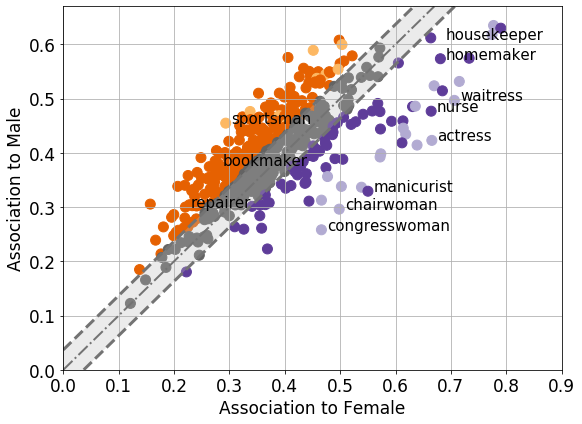

In [568]:

fsize=17
fsize2=15

#colors=['#74c476','#31a354','#005a32','black']
markers=['o','^','v','D']
lss=['-','-.','--','-','-','-','-','-']

_bias_expectation_fem = SG_2nd_mean_bias_expectation_fem_scaled #SG_2nd_cosine_bias_expectation_fem#_scaled
_bias_expectation_mas = SG_2nd_mean_bias_expectation_mas_scaled #SG_2nd_cosine_bias_expectation_mas#_scaled
_bias = job_SG_2nd_mean_bias_scaled #job_SG_2nd_cosine_bias_scaled

X=[x[2] for x in _bias]
Y=[x[3] for x in _bias]

fig, ax= plt.subplots(nrows=1, ncols=1 , figsize=(8, 6))

_color_unbiasedarea='#bdbdbd'
_color_unbiasedborder='#737373'
_color_unbiasedpnt='#636363'
_color_biasedbad_female='#5e3c99'
_color_biasedgood_female='#b2abd2'
_color_biasedbad_male='#e66101'
_color_biasedgood_male='#fdb863'

_colors=[]
for _tuple in [x for x in _bias]:
    _isbiased=(_tuple[2]>_tuple[3] and _tuple[2]-_tuple[3]>_bias_expectation_fem) or (_tuple[2]<_tuple[3] and abs(_tuple[2]-_tuple[3])>abs(_bias_expectation_mas))
    if _isbiased:
        if _tuple[2]>_tuple[3]: #female
            if _tuple[4]=='n':
                _colors.append(_color_biasedbad_female)
            else:
                _colors.append(_color_biasedgood_female)
        else:
            if _tuple[4]=='n':
                _colors.append(_color_biasedbad_male)
            else:
                _colors.append(_color_biasedgood_male)
    else:
        if _tuple[4]=='n':
            _colors.append(_color_unbiasedpnt)
        elif _tuple[4]=='m':
            _colors.append(_color_biasedgood_male)
        elif _tuple[4]=='f':
            _colors.append(_color_biasedgood_female)



#max_x=0.93
#max_y=0.7
max_x=0.9
max_y=0.67



    
ax.scatter(X, Y, c=_colors, s=100, alpha=1.0)

for i, _item in enumerate(_bias):
    _lbl=_item[0]
    if _lbl in ['homemaker', 'waitress', 'hairdresses', 'bookmaker',
                'nurse','sportsman','',
                'repairer','','housekeeper','manicurist',
                'congresswoman','chairwoman','','','',
                '','actress','','']:
    #if _lbl in ['', 'waitress', 'hairdresses', '',
    #            '','','',
    #            'nanny','mistress','','',
    #            '','nanny','','','',
    #            '','actress','ballerina','sportsman']:
        #_lbl=_lbl[:1].upper()+_lbl[1:]
        if _lbl in ['housekeeper']:
            ax.annotate(_lbl, (X[i]-0.1,Y[i]-0.02), fontsize=fsize2)
        #elif _lbl in ['Physician']:
        #    ax.annotate(_lbl, (X[i],Y[i]-0.011), fontsize=fsize2)
        else:
            ax.annotate(_lbl, (X[i]+0.01,Y[i]), fontsize=fsize2)
    #ax.annotate(_lbl, (X[i]+0.005,Y[i]+0.002), fontsize=fsize2)


ax.plot((0, max_y), (0, max_y), c=_color_unbiasedborder, ls='-.', lw=2)
ax.plot((0, max_y+0.01), (abs(_bias_expectation_mas), max_y+abs(_bias_expectation_mas)+0.01), c=_color_unbiasedborder, ls='--', lw=3)
ax.plot((_bias_expectation_fem, max_y+_bias_expectation_fem), (0, max_y), c=_color_unbiasedborder, ls='--', lw=3)

ax.fill_between([0,max_y+0.04], 
                [abs(_bias_expectation_mas), max_y+abs(_bias_expectation_mas)+0.04],
                [-abs(_bias_expectation_fem), max_y-abs(_bias_expectation_fem)+0.04],
                facecolor=_color_unbiasedarea, alpha=0.3, interpolate=True)


ax.tick_params(axis='both', which='major', labelsize=fsize)
ax.set_xlabel('Association to Female', fontsize=fsize)
ax.set_ylabel('Association to Male', fontsize=fsize)
ax.set_xlim(0, max_x)
ax.set_ylim(0, max_y)
ax.grid(True)

fig.tight_layout()
plt.show()
fig.set_size_inches(8, 6)
fig.savefig('plots/job_SG_2nd_mean_bias.pdf', dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)





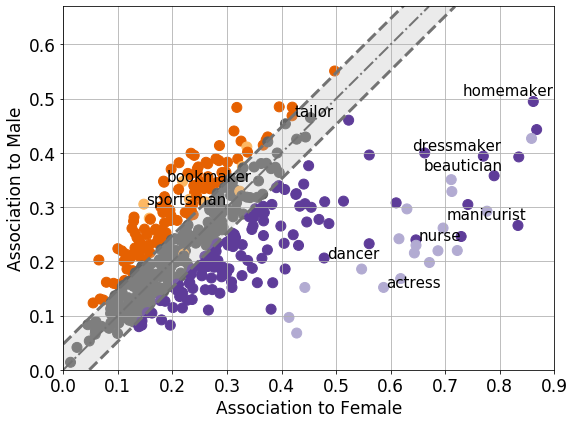

In [569]:


fsize=17
fsize2=15

#colors=['#74c476','#31a354','#005a32','black']
markers=['o','^','v','D']
lss=['-','-.','--','-','-','-','-','-']

_bias_expectation_fem = recSG_1st_mean_bias_expectation_fem_scaled
_bias_expectation_mas = recSG_1st_mean_bias_expectation_mas_scaled
_bias = job_recSG_1st_mean_bias_scaled
#_bias_expectation_fem = exp_bias_expectation_fem_scaled
#_bias_expectation_mas = exp_bias_expectation_mas_scaled
#_bias = job_exp_bias_scaled



X=[x[2] for x in _bias]
Y=[x[3] for x in _bias]

fig, ax= plt.subplots(nrows=1, ncols=1 , figsize=(8, 6))

_color_unbiasedarea='#bdbdbd'
_color_unbiasedborder='#737373'
_color_unbiasedpnt='#636363'
_color_biasedbad_female='#5e3c99'
_color_biasedgood_female='#b2abd2'
_color_biasedbad_male='#e66101'
_color_biasedgood_male='#fdb863'



_colors=[]
for _tuple in [x for x in _bias]:
    _isbiased=(_tuple[2]>_tuple[3] and _tuple[2]-_tuple[3]>_bias_expectation_fem) or (_tuple[2]<_tuple[3] and abs(_tuple[2]-_tuple[3])>abs(_bias_expectation_mas))
    if _isbiased:
        if _tuple[2]>_tuple[3]: #female
            if _tuple[4]=='n':
                _colors.append(_color_biasedbad_female)
            else:
                _colors.append(_color_biasedgood_female)
        else:
            if _tuple[4]=='n':
                _colors.append(_color_biasedbad_male)
            else:
                _colors.append(_color_biasedgood_male)
    else:
        if _tuple[4]=='n':
            _colors.append(_color_unbiasedpnt)
        elif _tuple[4]=='m':
            _colors.append(_color_biasedgood_male)
        elif _tuple[4]=='f':
            _colors.append(_color_biasedgood_female)



#max_x=0.93
#max_y=0.7
max_x=0.9
max_y=0.67




    
ax.scatter(X, Y, c=_colors, s=100, alpha=1.0)

for i, _item in enumerate(_bias):
    _lbl=_item[0]
    if _lbl in ['homemaker', 'bookmaker', 'hairdresses', '',
                'tailor','dressmaker','nurse',
                '','','','manicurist',
                'dancer','','beautician','','',
                '','actress','','sportsman']:
        #_lbl=_lbl[:1].upper()+_lbl[1:]
        if _lbl in ['dressmaker','beautician','homemaker','manicurist']:
            ax.annotate(_lbl, (X[i]-0.13,Y[i]+0.011), fontsize=fsize2)
        else:
            ax.annotate(_lbl, (X[i]+0.005,Y[i]), fontsize=fsize2)
    #ax.annotate(_lbl, (X[i]+0.005,Y[i]+0.002), fontsize=fsize2)
    
ax.plot((0, max_y), (0, max_y), c=_color_unbiasedborder, ls='-.', lw=2)
ax.plot((0, max_y+0.01), (abs(_bias_expectation_mas), max_y+abs(_bias_expectation_mas)+0.01), c=_color_unbiasedborder, ls='--', lw=3)
ax.plot((_bias_expectation_fem, max_y+_bias_expectation_fem), (0, max_y), c=_color_unbiasedborder, ls='--', lw=3)
ax.fill_between([0,max_y+0.04], 
                [abs(_bias_expectation_mas), max_y+abs(_bias_expectation_mas)+0.04],
                [-abs(_bias_expectation_fem), max_y-abs(_bias_expectation_fem)+0.04],
                facecolor=_color_unbiasedarea, alpha=0.3, interpolate=True)

ax.tick_params(axis='both', which='major', labelsize=fsize)
ax.set_xlabel('Association to Female', fontsize=fsize)
ax.set_ylabel('Association to Male', fontsize=fsize)
ax.set_xlim(0.0, max_x)
ax.set_ylim(0.0, max_y)
ax.grid(True)

fig.tight_layout()
plt.show()
fig.set_size_inches(8, 6)
#fig.savefig('plots/job_recSG_1st_mean_bias_scaled.pdf', dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)






-0.17006620624916496 0.24260927532936466


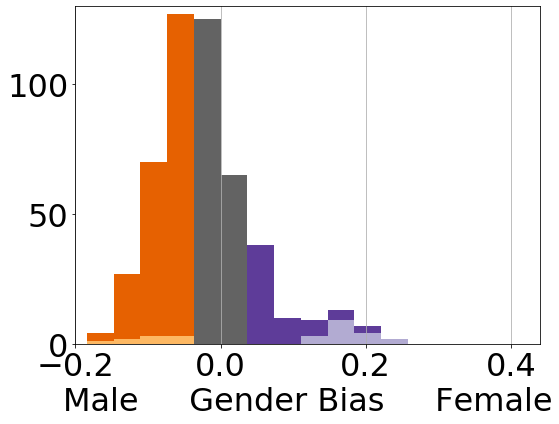

In [118]:

fsize=32
fsize2=18

#colors=['#74c476','#31a354','#005a32','black']
markers=['o','^','v','D']
lss=['-','-.','--','-','-','-','-','-']

_bias_expectation_fem = SG_2nd_mean_bias_expectation_fem_scaled
_bias_expectation_mas = SG_2nd_mean_bias_expectation_mas_scaled
_bias = job_SG_2nd_mean_bias_scaled

fig, ax= plt.subplots(nrows=1, ncols=1 , figsize=(8, 6))

_color_unbiasedarea='#bdbdbd'
_color_unbiasedborder='#737373'
_color_unbiasedpnt='#636363'
_color_biasedgood='blue'#'#bae4b3'
_color_biasedbad='#de2d26'
_color_biasedbad_female='#5e3c99'
_color_biasedgood_female='#b2abd2'
_color_biasedbad_male='#e66101'
_color_biasedgood_male='#fdb863'



hist_colors = [_color_biasedgood_female, _color_biasedbad_female, _color_biasedgood_male, _color_biasedbad_male, _color_unbiasedpnt]
X=[[], [], [], [], []]
for _tuple in [x for x in _bias]:
    _isbiased=(_tuple[2]>_tuple[3] and _tuple[2]-_tuple[3]>_bias_expectation_fem) or (_tuple[2]<_tuple[3] and abs(_tuple[2]-_tuple[3])>abs(_bias_expectation_mas))
    if _isbiased:
        if _tuple[2]>_tuple[3]: #female
            if _tuple[4]=='n':
                X[1].append(_tuple[1])
            else:
                X[0].append(_tuple[1])
        else: # male
            if _tuple[4]=='n':
                X[3].append(_tuple[1])
            else:
                X[2].append(_tuple[1])
    else:
        if _tuple[4]=='n':
            X[4].append(_tuple[1])
        elif _tuple[4]=='f':
            X[0].append(_tuple[1])
        elif _tuple[4]=='m':
            X[2].append(_tuple[1])
        

min_x=-0.2
max_x=0.44
max_y=130

print(np.min(np.min(X)), np.max(np.max(X)))


bins = list(np.arange(0, min_x, -_bias_expectation_fem)[::-1]) + list(np.arange(0, 0.47, _bias_expectation_fem))
ax.hist(X, bins=bins, histtype='bar', stacked=True, color=hist_colors)

ax.tick_params(which='major', labelsize=fsize)
ax.set_xlabel('Male     Gender Bias     Female', fontsize=fsize)
ax.set_xlim(min_x, max_x)
ax.set_ylim(0, max_y)
plt.gca().xaxis.grid(True)

fig.tight_layout()
plt.show()
fig.set_size_inches(8, 6)
fig.savefig('plots/job_SG_2nd_mean_bias_histogram.pdf', dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)




-0.17218194167009163 0.5020604301376428


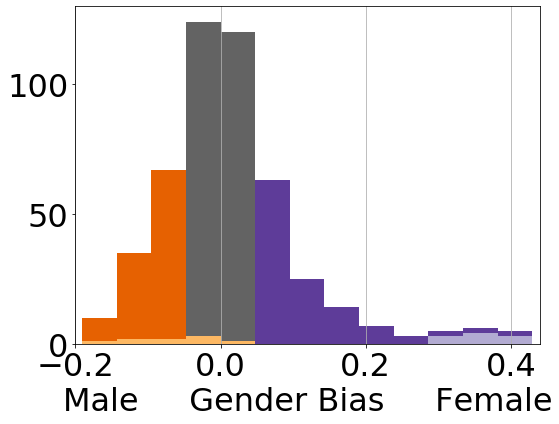

In [119]:

fsize=32
fsize2=24

#colors=['#74c476','#31a354','#005a32','black']
markers=['o','^','v','D']
lss=['-','-.','--','-','-','-','-','-']

_bias_expectation_fem = recSG_1st_mean_bias_expectation_fem_scaled
_bias_expectation_mas = recSG_1st_mean_bias_expectation_mas_scaled
_bias = job_recSG_1st_mean_bias_scaled


fig, ax= plt.subplots(nrows=1, ncols=1 , figsize=(8, 6))


_color_unbiasedarea='#bdbdbd'
_color_unbiasedborder='#737373'
_color_unbiasedpnt='#636363'
_color_biasedbad_female='#5e3c99'
_color_biasedgood_female='#b2abd2'
_color_biasedbad_male='#e66101'
_color_biasedgood_male='#fdb863'



hist_colors = [_color_biasedgood_female, _color_biasedbad_female, _color_biasedgood_male, _color_biasedbad_male, _color_unbiasedpnt]
X=[[], [], [], [], []]
for _tuple in [x for x in _bias]:
    _isbiased=(_tuple[2]>_tuple[3] and _tuple[2]-_tuple[3]>_bias_expectation_fem) or (_tuple[2]<_tuple[3] and abs(_tuple[2]-_tuple[3])>abs(_bias_expectation_mas))
    if _isbiased:
        if _tuple[2]>_tuple[3]: #female
            if _tuple[4]=='n':
                X[1].append(_tuple[1])
            else:
                X[0].append(_tuple[1])
        else: # male
            if _tuple[4]=='n':
                X[3].append(_tuple[1])
            else:
                X[2].append(_tuple[1])
    else:
        if _tuple[4]=='n':
            X[4].append(_tuple[1])
        elif _tuple[4]=='f':
            X[0].append(_tuple[1])
        elif _tuple[4]=='m':
            X[2].append(_tuple[1])


#-0.21697625304746915 0.4459305321100774
min_x=-0.2
max_x=0.44
max_y=130

print(np.min(np.min(X)), np.max(np.max(X)))
bins = list(np.arange(0, min_x, -_bias_expectation_fem)[::-1]) + list(np.arange(0, 0.47, _bias_expectation_fem))
ax.hist(X, bins=bins, histtype='bar', stacked=True, color=hist_colors)

ax.tick_params(which='major', labelsize=fsize)
ax.set_xlabel('Male     Gender Bias     Female', fontsize=fsize)
ax.set_xlim(min_x, max_x)
ax.set_ylim(0, max_y)
plt.gca().xaxis.grid(True)

fig.tight_layout()
plt.show()
fig.set_size_inches(8, 6)
fig.savefig('plots/job_recSG_1st_mean_bias_scaled_histogram.pdf', dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)




### Analysis of Bias

In [ ]:
_bias_expectation_fem = recSG_1st_mean_bias_expectation_fem_scaled
_bias_expectation_mas = recSG_1st_mean_bias_expectation_mas_scaled
_bias = job_recSG_1st_mean_bias_scaled


_lst = [x for x in _bias if x[4]=='m' and x[1]>0 and abs(x[1])>abs(_bias_expectation_mas)]
_lst.sort(key=lambda x: x[1])
print (len(_lst))
print ([x[0] for x in _lst][:82])

_lst = [x for x in _bias if x[4]=='f' and x[1]<0 and abs(x[1])>abs(_bias_expectation_fem)]
_lst.sort(key=lambda x: x[1], reverse = True)
print (len(_lst))
print ([x[0] for x in _lst])

_bias_expectation_fem = SG_2nd_mean_bias_expectation_fem_scaled
_bias_expectation_mas = SG_2nd_mean_bias_expectation_mas_scaled
_bias = job_SG_2nd_mean_bias_scaled

_lst = [x for x in _bias if x[4]=='m' and x[1]>0 and abs(x[1])>abs(_bias_expectation_mas)]
_lst.sort(key=lambda x: x[1])
print (len(_lst))
print ([x[0] for x in _lst][:82])

_lst = [x for x in _bias if x[4]=='f' and x[1]<0 and abs(x[1])>abs(_bias_expectation_fem)]
_lst.sort(key=lambda x: x[1], reverse = True)
print (len(_lst))
print ([x[0] for x in _lst])




In [219]:
job_SG_2nd_mean_bias.sort(key=lambda x:x[1])
print ([(x[0], x[4]) for x in job_SG_2nd_mean_bias if x[4]=='n'][:5])
print ([(x[0], x[4]) for x in job_SG_2nd_mean_bias[::-1] if x[4]=='n'][:5])


[('captain', 'n'), ('colonel', 'n'), ('mechanician', 'n'), ('lieutenant', 'n'), ('engineer', 'n')]
[('manicurist', 'n'), ('midwife', 'n'), ('nurse', 'n'), ('socialite', 'n'), ('housekeeper', 'n')]


#### the most important context words contributing to bias



In [563]:
#the most important context words contributing to bias using 2nd_mean on rec vectors


_lst = []
for _tuple_2nd in job_SG_2nd_mean_bias:
    for _tuple_1st in job_recSG_1st_mean_bias:
        if _tuple_2nd[0] == _tuple_1st[0]:
            _lst.append((_tuple_2nd[0], _tuple_1st[1] - _tuple_2nd[1])) 

_lst.sort(key=lambda x: abs(x[1]), reverse=True)
_lst = _lst[:5]
print (_lst)



    
for _job in ['manicurist','midwife','nurse','captain','colonel','mechanician']:
    _vec = job_recSG_vecs[_job]
    
    _fem_recSG_mean = np.zeros(len(_vec))
    for _rec_vec in fem_recSG_vecs:
        _fem_recSG_mean += (_vec/LA.norm(_vec)) * (_rec_vec/LA.norm(_rec_vec))
    _fem_recSG_mean /= len(fem_recSG_vecs)

    _masc_recSG_mean = np.zeros(len(_vec))
    for _rec_vec in masc_recSG_vecs:
        _masc_recSG_mean += (_vec/LA.norm(_vec)) * (_rec_vec/LA.norm(_rec_vec))
    _masc_recSG_mean /= len(masc_recSG_vecs)
    
    _bias_recSG_mean = _fem_recSG_mean - _masc_recSG_mean
    
    _mult = list(zip((_bias_recSG_mean), we_model.wv.index2word))
    
    _mult.sort(key=lambda x:x[0], reverse=True)
    print (_job)
    print ('Towards female:', [x[1] for x in _mult][:5])
    print ('Towards   male:', [x[1] for x in _mult][::-1][:5])
    _mult.sort(key=lambda x:abs(x[0]), reverse=True)
    print ('Both          :', [x[1] for x in _mult][:5])
    print ()


#masc_recSG_vecs = []


[('manicurist', 0.1893300979323352), ('maid', 0.1644249494254057), ('midwife', 0.15850828195522937), ('matron', 0.15812803325908525), ('beautician', 0.15733857166820342)]
captain
Towards female: ['amelia', 'matron', 'eliza', 'nurse', 'gwendoline']
Towards   male: ['commanded', 'capt', 'quartermaster', 'enlisted', 'hugh']
Both          : ['commanded', 'capt', 'quartermaster', 'enlisted', 'amelia']

colonel
Towards female: ['matron', 'nurse', 'nursing', 'louisa', 'louise']
Towards   male: ['commanded', 'hugh', 'ernest', 'guards', 'quartermaster']
Both          : ['commanded', 'matron', 'hugh', 'ernest', 'guards']

mechanician
Towards female: ['aleksandrovna', 'ivanovna', 'vladimirovna', 'winifred', 'evna']
Towards   male: ['apprenticed', 'cyril', 'ernest', 'messrs', 'surveyor']
Both          : ['apprenticed', 'cyril', 'ernest', 'messrs', 'surveyor']

manicurist
Towards female: ['businesswoman', 'nurse', 'filipina', 'seamstress', 'matron']
Towards   male: ['salesman', 'mechanic', 'roofer'

In [561]:
_lst

[('captain', 0.041666545880226655),
 ('sportsman', 0.005289962432081116),
 ('colonel', 0.03503594401159456),
 ('mechanician', 0.009196097536395054),
 ('lieutenant', 0.03663674208551778),
 ('engineer', 0.03292378315901649),
 ('foreman', 0.012301024481920275),
 ('businessman', 0.007865209431786632),
 ('draughtsman', 0.007995101904400947),
 ('sergeant', 0.04098773469948875),
 ('surveyor', 0.0007544527927945827),
 ('marshal', 0.012184247661415237),
 ('stonemason', -0.02360062748526358),
 ('chairman', 0.05607599108147301),
 ('metallurgist', -0.014243236961192465),
 ('soldier', 0.022491115245169835),
 ('cartographer', 0.007051882437995788),
 ('industrialist', -0.01750754169812091),
 ('financier', 0.0013060651960716124),
 ('constable', 0.014285379596653228),
 ('stuntman', 0.001863191043542295),
 ('commander', 0.03691764564220127),
 ('manager', 0.0478767293139494),
 ('proprietor', 0.011609030854223046),
 ('electrician', -0.00034287498731699895),
 ('chief', 0.04540140948457912),
 ('sheriff', 0.